In [ ]:
from random import randrange


def generate_list(size: int) -> list[int]:
    '''Generates a list of random numbers of length `size`, on numbers on `range(size)`'''
    return [randrange(size) for i in range(size)]


In [ ]:
def merge(a: list[int], b: list[int]) -> list[int]:
    '''Merges two lists `a` and `b` into a single sorted list'''
    i = j = 0
    result = []
    while i < len(a) and j < len(b):
        if a[i] < b[j]:
            result.append(a[i])
            i += 1
        else:
            result.append(b[j])
            j += 1
    result += a[i:]
    result += b[j:]
    return result


def sort(list: list[int], job_id: int) -> list[int]:
    list.sort()
    # print(f"Job {job_id}:\tSorted {len(list)} elements")
    return list


In [ ]:
from threading import Thread


def mergesort_thread(list: list[int], division: int) -> list[int]:
    '''Sorts a list using in-place non-recursive mergesort, where it splits the job size into `division` slices and sorts each slice in a single unit, then joing them back using units aswell'''
    if len(list) <= division:
        print("List is too small to split")
        return list

    # Only the last element can be 1 smaller, only if necessary
    slices = []
    slice_size = len(list) // division
    for i in range(division):
        if i == division - 1:
            # Last slice does not need to be the same size
            slices.append(list[i * slice_size:])
        else:
            slices.append(list[i * slice_size:(i + 1) * slice_size])

    # Sort each slice in a job
    sort_jobs = [Thread(target=sort, args=(slice, i))
               for (i, slice) in enumerate(slices)]
    for job in sort_jobs:
        job.start()

    # Sync point: join the divisions back
    for job in sort_jobs:
        job.join()

    # Merge pairs of the now sorted slices using jobs:
    while len(slices) > 1:
        merge_jobs = []
        for i in range(0, len(slices), 2):
            if i + 1 < len(slices):
                merge_jobs.append(
                    Thread(target=merge, args=(slices[i], slices[i + 1])))
            else:
                # Only the last may not join, if the list is odd length
                merge_jobs.append(Thread(target=merge, args=(slices[i], [])))

        for job in merge_jobs:
            job.start()
        for job in merge_jobs:
            job.join()

        slices = [slices[i] for i in range(0, len(slices), 2)]

    return slices[0]


In [ ]:
from multiprocessing import Process, Queue, Array, Value


def sort_queue(slice, job_id: int):
    '''Sorts a list in a job, and puts it back in the queue'''
    slice = sort(slice[:], job_id)
    return slice

def mergesort_process_queue(list: list[int], division: int) -> list[int]:
    '''Sorts a list using in-place non-recursive mergesort, where it splits the job size into `division` slices and sorts each slice in a single unit, then joing them back using units aswell'''
    if len(list) <= division:
        print("List is too small to split")
        return list

    # Only the last element can be 1 smaller, only if necessary
    slices = []
    slice_size = len(list) // division
    for i in range(division):
        if i == division - 1:
            # Last slice does not need to be the same size
            slices.append(Array('i', list[i * slice_size:]))
        else:
            slices.append(Array('i', list[i * slice_size:(i + 1) * slice_size]))

    # Queue for shared memory
    queue = Queue()

    # Sort each slice in a job
    sort_jobs = [Process(target=sort_queue, args=(slice, i))
               for (i, slice) in enumerate(slices)]
    for job in sort_jobs:
        job.start()

    # Sync point: join the divisions back
    for job in sort_jobs:
        job.join()

    # Merge pairs of the now sorted slices using jobs:
    while len(slices) > 1:
        merge_jobs = []
        for i in range(0, len(slices), 2):
            if i + 1 < len(slices):
                merge_jobs.append(
                    Process(target=merge, args=(slices[i], slices[i + 1])))
            else:
                # Only the last may not join, if the list is odd length
                merge_jobs.append(Process(target=merge, args=(slices[i], [])))

        for job in merge_jobs:
            job.start()
        for job in merge_jobs:
            job.join()

        slices = [slices[i] for i in range(0, len(slices), 2)]

    return slices[0]


In [ ]:
from multiprocessing import Pipe



def mergesort_process_pipe(list: list[int], division: int) -> list[int]:
    '''Sorts a list using in-place non-recursive mergesort, where it splits the job size into `division` slices and sorts each slice in a single unit, then joing them back using units aswell'''
    if len(list) <= division:
        print("List is too small to split")
        return list

    # Only the last element can be 1 smaller, only if necessary
    slices = []
    slice_size = len(list) // division
    for i in range(division):
        if i == division - 1:
            # Last slice does not need to be the same size
            slices.append(list[i * slice_size:])
        else:
            slices.append(list[i * slice_size:(i + 1) * slice_size])

    # Queue for shared memory
    queue = Queue()
    queue.put(slices)

    # Sort each slice in a job
    sort_jobs = [Process(target=sort_queue, args=(q, i))
               for (i, slice) in enumerate(slices)]
    for job in sort_jobs:
        job.start()

    # Sync point: join the divisions back
    for job in sort_jobs:
        job.join()

    # Merge pairs of the now sorted slices using jobs:
    while len(slices) > 1:
        merge_jobs = []
        for i in range(0, len(slices), 2):
            if i + 1 < len(slices):
                merge_jobs.append(
                    Process(target=merge, args=(slices[i], slices[i + 1])))
            else:
                # Only the last may not join, if the list is odd length
                merge_jobs.append(Process(target=merge, args=(slices[i], [])))

        for job in merge_jobs:
            job.start()
        for job in merge_jobs:
            job.join()

        slices = [slices[i] for i in range(0, len(slices), 2)]

    return slices[0]

In [ ]:
from typing import Callable
from time import time

def assert_is_ordered(list: list[int]):
    print(f"{list}")
    for i in range(len(list) - 1):
        assert list[i] <= list[i+1], "list is not ordered"

def run(list_size: int, rounds: int, parallels: int, func: Callable[list[int], int]) -> list[float]:
    '''gens 1 new list per round, to decrease variability'''

    times = []
    print(
        f"Running {func.__name__} for list size {list_size} and {rounds} rounds")

    for round in range(rounds):
        list = generate_list(list_size)

        # record time elapsed
        start = time()
        list = func(list, parallels)
        elapsed = time() - start

        assert_is_ordered(list)
        # print(f"Round {round + 1}: \t{elapsed}")
        print(".", end="", flush=True)
        times.append(elapsed)
    print()

    return times


In [ ]:
import multiprocessing as mp
    
# process_10_1 = run(list_size=10, rounds=20,
                    # parallels=1, func=mergesort_process_queue)
threaded_50k_1 = run(list_size=50000, rounds=20,
                    parallels=1, func=mergesort_thread)
# process_50k_1 = run(list_size=50000, rounds=20,
                    # parallels=1, func=mergesort_process_queue)
threaded_50k_2 = run(list_size=50000, rounds=20,
                    parallels=2, func=mergesort_thread)
# process_50k_2 = run(list_size=50000, rounds=20,
                    # parallels=2, func=mergesort_process_queue)
threaded_50k_4 = run(list_size=50000, rounds=20,
                    parallels=4, func=mergesort_thread)
# process_50k_4 = run(list_size=50000, rounds=20,
                    # parallels=4, func=mergesort_process_queue)
threaded_50k_8 = run(list_size=50000, rounds=20,
                    parallels=8, func=mergesort_thread)
# process_50k_8 = run(list_size=50000, rounds=20,
                    # parallels=8, func=mergesort_process_queue)



In [ ]:
import pandas as pd

# import all the results into a pandas dataframe
df_1t = pd.DataFrame(threaded_50k_1, columns=["1 thread"])
df_2t = pd.DataFrame(threaded_50k_2, columns=["2 threads"])
df_4t = pd.DataFrame(threaded_50k_4, columns=["4 threads"])
df_8t = pd.DataFrame(threaded_50k_8, columns=["8 threads"])
df_threaded = pd.concat([df_1t, df_2t, df_4t, df_8t], axis=1)

# df_1p = pd.DataFrame(process_500k_1, columns=["1 process"])
# df_2p = pd.DataFrame(process_500k_2, columns=["2 processes"])
# df_4p = pd.DataFrame(process_500k_4, columns=["4 processes"])
# df_8p = pd.DataFrame(process_500k_8, columns=["8 processes"])
# df_process = pd.concat([df_1p, df_2p, df_4p, df_8p], axis=1)

df = pd.concat([df_threaded], axis=1)

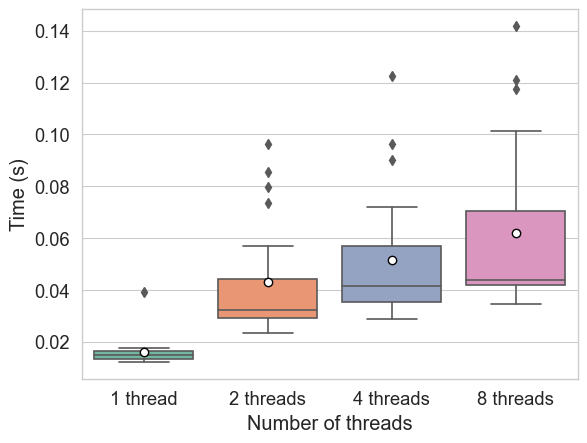

In [14]:
    import seaborn as sns
    import matplotlib as plt


    def plot(data: pd.DataFrame):
        '''Plots a list of lists of times, each list is a different algorithm'''
        # dict keys are labels and values are lists of times
        sns.set_theme()
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale=1.5)
        sns.set_palette("Set2")
        sns.boxplot(data=data, showmeans=True, meanprops={
                    "marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"})
        plt.pyplot.xlabel("Number of threads")
        plt.pyplot.ylabel("Time (s)")
        plt.pyplot.show()


    plot(df)
